In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.7.1+cu118
True
NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
import itertools
import json
import joblib

from src.dataset_loaders import get_ptb_xl_fmm_dataset, get_shaoxing_fmm_dataset
from src.preprocess_data import preprocess_data_fmm

from src.models.VAE import VAE1D, compute_scores
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve, confusion_matrix

In [3]:
%load_ext autoreload
%autoreload 2

### `Load the Data`

In [ ]:
from src.utils import find_data_subfolder, find_folder

DATA_DIR = find_data_subfolder('')

In [5]:
print("Loading FMM-enhanced PTB-XL dataset...")
data_dict_ptb_xl = get_ptb_xl_fmm_dataset(
    datapath=DATA_DIR,
    num_leads=1,
    lead=0,
    num_waves=5,
    sequence_length=2048,
    delete_high_A=False
)
print("Dataset loaded successfully.")

Loading FMM-enhanced PTB-XL dataset...


Loading 'test': 100%|██████████| 10907/10907 [01:01<00:00, 177.22it/s]


Dataset loaded successfully.


In [9]:
print("Loading FMM-enhanced Shaoxing dataset...")
data_dict_shaoxing = get_shaoxing_fmm_dataset(
    datapath=DATA_DIR,
    num_leads=1,
    lead=0,  
    num_waves=5,
    sequence_length=2048,
    delete_high_A=False
)
print("Dataset loaded successfully.")

Loading FMM-enhanced Shaoxing dataset...


Loading 'all': 100%|██████████| 69845/69845 [05:19<00:00, 218.54it/s] 


Dataset loaded successfully.


In [ ]:
print("PTB-XL keys:", data_dict_ptb_xl.keys())
print("Shaoxing keys:", data_dict_shaoxing.keys())

PTB-XL keys: dict_keys(['train', 'test', 'params'])
Shaoxing keys: dict_keys(['train', 'test', 'params'])


#### Join the datasets

In [ ]:
ptb = data_dict_ptb_xl
shx = data_dict_shaoxing

# Train
data_dict_train = {
    'data':             np.concatenate([ptb["train"]['data'],            shx["train"]['data']           ], axis=0),
    'labels':           np.concatenate([ptb["train"]['labels'],          shx["train"]['labels']         ], axis=0),
    'sizes':            np.concatenate([ptb["train"]['sizes'],           shx["train"]['sizes']          ], axis=0),
    'coefficients':     np.concatenate([ptb["train"]['coefficients'],    shx["train"]['coefficients']   ], axis=0),
    'coefficients_ang': np.concatenate([ptb["train"]['coefficients_ang'],shx["train"]['coefficients_ang']], axis=0),
}

# Test
data_dict_test = {
    'data':             np.concatenate([ptb["test"]['data'],            shx["test"]['data']           ], axis=0),
    'labels':           np.concatenate([ptb["test"]['labels'],          shx["test"]['labels']         ], axis=0),
    'sizes':            np.concatenate([ptb["test"]['sizes'],           shx["test"]['sizes']          ], axis=0),
    'coefficients':     np.concatenate([ptb["test"]['coefficients'],    shx["test"]['coefficients']   ], axis=0),
    'coefficients_ang': np.concatenate([ptb["test"]['coefficients_ang'],shx["test"]['coefficients_ang']], axis=0),
}

# ambos usan el mismo normal_class
data_dict_params = ptb["params"]  # o shx["params"], coinciden

data_dict = {
    "train":  data_dict_train,
    "test":   data_dict_test,
    "params": data_dict_params
}

### `Preprocess the data`
Recortamos cada array para que su número de muestras sea múltiplo de batch_size

Todavía no se aplica ningún tipo de normalización o data augmentation, por lo que la lógica es la misma en train y test

In [10]:
raw_dev = {
    "data":            data_dict["train"]["data"], 
    "labels":          data_dict["train"]["labels"],
    "sizes":           data_dict["train"]["sizes"],
    "coefficients":    data_dict["train"]["coefficients"],
    "coefficients_ang":data_dict["train"]["coefficients_ang"],
}
dev_proc = preprocess_data_fmm(
    raw_dev,
    dataset_params=data_dict["params"],
    fs=100,
    batch_size=32,
    split_ecg=False
)

raw_test = {
    "data":            data_dict["test"]["data"], 
    "labels":          data_dict["test"]["labels"],
    "sizes":           data_dict["test"]["sizes"],
    "coefficients":    data_dict["test"]["coefficients"],
    "coefficients_ang":data_dict["test"]["coefficients_ang"],
}

test_proc = preprocess_data_fmm(
    raw_dev,
    dataset_params=data_dict["params"],
    fs=100,
    batch_size=32,
    split_ecg=False
)

Number of samples per class: [np.int64(11586), np.int64(3019), np.int64(14707), np.int64(54056), np.int64(13127)]
Number of samples per class: [np.int64(11586), np.int64(3019), np.int64(14707), np.int64(54056), np.int64(13127)]


In [11]:
data_dict = {
    "train": dev_proc,
    "test":  test_proc,
    "params": data_dict["params"]
}

#### Extract signals and coefficients

In [ ]:
X_dev_signal_raw = data_dict['train']['data'].astype(np.float32)
X_dev_coeffs_raw = data_dict['train']['coefficients'].astype(np.float32)
y_dev = data_dict['train']['labels'].astype(int)

X_test_signal_raw = data_dict['test']['data'].astype(np.float32)
X_test_coeffs_raw = data_dict['test']['coefficients'].astype(np.float32)
y_test = data_dict['test']['labels'].astype(int)

print("Data loading complete.")
print(f"Train signal shape: {X_dev_signal_raw.shape}, Train coeffs shape: {X_dev_coeffs_raw.shape}")

Data loading complete.
Train signal shape: (151584, 2048, 1), Train coeffs shape: (151584, 21)


In [ ]:
normal_class_id = data_dict['params']['normal_class']

dev_norm_signal_raw = X_dev_signal_raw[y_dev == normal_class_id]
dev_norm_coeffs_raw = X_dev_coeffs_raw[y_dev == normal_class_id]
dev_ano_signal_raw = X_dev_signal_raw[y_dev != normal_class_id] 
dev_ano_coeffs_raw = X_dev_coeffs_raw[y_dev != normal_class_id]

#### Torch Tensors

In [14]:
dev_norm_signal_tensor_raw = torch.tensor(dev_norm_signal_raw).permute(0, 2, 1)
dev_ano_signal_tensor_raw = torch.tensor(dev_ano_signal_raw).permute(0, 2, 1)

dev_norm_coeffs_tensor_raw = torch.tensor(dev_norm_coeffs_raw)
dev_ano_coeffs_tensor_raw = torch.tensor(dev_ano_coeffs_raw)

### Normalize the data

In [16]:
mean_x = dev_norm_signal_raw.mean()
std_x  = dev_norm_signal_raw.std()
mean_c = dev_norm_coeffs_raw.mean(axis=0)
std_c  = dev_norm_coeffs_raw.std(axis=0)

In [15]:
X_dev_signal = (X_dev_signal_raw - mean_x) / (std_x  + 1e-8)
X_test_signal  = (X_test_signal_raw  - mean_x) / (std_x  + 1e-8)

X_dev_coeffs = (X_dev_coeffs_raw - mean_c) / (std_c  + 1e-8)
X_test_coeffs  = (X_test_coeffs_raw  - mean_c) / (std_c  + 1e-8)

#### Normilized splits

In [16]:
dev_norm_signal = X_dev_signal[y_dev == normal_class_id]
dev_norm_coeffs = X_dev_coeffs[y_dev == normal_class_id]
dev_ano_signal  = X_dev_signal[y_dev != normal_class_id]
dev_ano_coeffs  = X_dev_coeffs[y_dev != normal_class_id]

test_norm_signal = X_test_signal[y_test == normal_class_id]
test_norm_coeffs = X_test_coeffs[y_test == normal_class_id] 
test_ano_signal  = X_test_signal[y_test != normal_class_id]
test_ano_coeffs  = X_test_coeffs[y_test != normal_class_id]

#### Tensors

In [17]:
# Conv1d espera (Batch, Channels, Length)

dev_norm_signal_tensor = torch.tensor(dev_norm_signal).permute(0, 2, 1)
dev_ano_signal_tensor = torch.tensor(dev_ano_signal).permute(0, 2, 1)
test_norm_signal_tensor = torch.tensor(test_norm_signal).permute(0, 2, 1)
test_ano_signal_tensor = torch.tensor(test_ano_signal).permute(0, 2, 1)

dev_norm_coeffs_tensor = torch.tensor(dev_norm_coeffs)
dev_ano_coeffs_tensor = torch.tensor(dev_ano_coeffs)
test_norm_coeffs_tensor = torch.tensor(test_norm_coeffs)
test_ano_coeffs_tensor = torch.tensor(test_ano_coeffs)

print(f"VAE training set size (normals only): {len(dev_norm_signal_tensor)}")
print(f"Final test set size (normals): {len(test_norm_signal_tensor)}")

VAE training set size (normals only): 54056
Final test set size (normals): 54056


## Save the data

In [ ]:
data_out_dir = find_folder('.', 'data')
out_dir_data_proc = data_out_dir + "data_out_dir"

os.makedirs(out_dir_data_proc, exist_ok=True)

np.savez_compressed(
    os.path.join(out_dir_data_proc, "data_processed.npz"),
    # Raw
    X_dev_signal_raw   = X_dev_signal_raw,
    X_dev_coeffs_raw   = X_dev_coeffs_raw,
    y_dev              = y_dev,
    X_test_signal_raw  = X_test_signal_raw, 
    X_test_coeffs_raw  = X_test_coeffs_raw,
    y_test             = y_test,

    # Normalizados
    X_dev_signal_normalized  = X_dev_signal,
    X_dev_coeffs_normalized  = X_dev_coeffs,
    X_test_signal_normalized = X_test_signal,
    X_test_coeffs_normalized = X_test_coeffs,

    # Parámetros de normalización
    mean_x             = mean_x,
    std_x              = std_x,
    mean_c             = mean_c,
    std_c              = std_c,

    normal_class_id    = normal_class_id,
)

In [21]:
batch_size = 64

# `HP sweep`

In [23]:
# Hacemos una función para dividir el set de dev sano sin normalizar. 
# Muestreamos anomalías para el set de validación y así poder probar métricas de qué tan bien separa.
# Y por último ormalizamos train y validación con las estadísticas de train.

from src.data_spitting import split_train_val_with_raw_dev

In [ ]:
train_ds, val_ds, stats, sig_tr, coe_tr, sig_vn, coe_vn, sig_va, coe_va, idx_val_ano = split_train_val_with_raw_dev(
    dev_norm_signal_raw, dev_norm_coeffs_raw,
    dev_ano_signal_raw,  dev_ano_coeffs_raw,
    val_frac=0.2, seed=42
) # Val tiene normales y anómalos, train no
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

labels_val = val_ds.tensors[2].numpy()

For XGBoost

In [ ]:
# Índices de anomalías para Train asegurándonos de no usar los de validación para no filtrar información
all_ano = np.arange(len(dev_ano_signal_raw))
idx_tr_ano = np.setdiff1d(all_ano, idx_val_ano) # complemento de idx_val_ano

# Normalizar anomalías
sig_tr_ano = (dev_ano_signal_raw[idx_tr_ano] - stats['mean_sig']) / stats['std_sig']
coe_tr_ano = (dev_ano_coeffs_raw[idx_tr_ano] - stats['mean_coe']) / stats['std_coe']

train_ano_signal_tensor = torch.tensor(sig_tr_ano).permute(0,2,1)
train_ano_coeffs_tensor = torch.tensor(coe_tr_ano)

train_norm_signal_tensor = train_ds.tensors[0]
train_norm_coeffs_tensor = train_ds.tensors[1]

Sweep

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
grid = {
    'beta': [1.0, 4.0, 10.0],
    'lr': [1e-3, 5e-4, 1e-4],
    'latent_dim': [16, 32, 64],
    'n_blocks': [2, 3]
}

combos = list(itertools.product( 
    grid['beta'], grid['lr'], grid['latent_dim'], grid['n_blocks']
))

hp_epochs = 15

In [ ]:
results = []

for beta, lr, latent_dim, n_blocks in tqdm(combos, desc="Hyperparam sweep", total=len(combos)):
    model = VAE1D(input_ch=1, coeff_ch=dev_norm_coeffs.shape[1], latent_dim=latent_dim, n_blocks=n_blocks).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Entrenamos sobre train_loader (solo normales)
    for _ in tqdm(range(hp_epochs), desc="VAE epochs", leave=False):
        model.train()
        for x_signal, x_coeffs, _ in train_loader:
            x_s, x_c = x_signal.to(device), x_coeffs.to(device)
            recon, mu, logv = model(x_s, x_c)
            recon_loss = nn.functional.mse_loss(recon, x_s)
            kl_loss = (-0.5 * (1 + logv - mu.pow(2) - logv.exp()).sum()) / x_s.size(0)
            loss = recon_loss + beta * kl_loss
            optimizer.zero_grad(); loss.backward(); optimizer.step()

    # ELBO en validación
    errs_val, zs_val = compute_scores(model, val_loader, device, beta)
    errs_val = np.nan_to_num(errs_val, nan=0.0, posinf=1e6, neginf=-1e6) # para NaNs/Infs
    scores_val = -errs_val
    labels_val = val_ds.tensors[2].numpy()
    vae_auc = roc_auc_score(labels_val, scores_val)
    
    # Train para XGB es normales + anómalos de Train
    X_tr_sigs  = torch.cat([train_norm_signal_tensor, train_ano_signal_tensor], dim=0)
    X_tr_coefs = torch.cat([train_norm_coeffs_tensor, train_ano_coeffs_tensor], dim=0)
    y_tr       = np.concatenate([
                     np.zeros(len(train_norm_signal_tensor)),
                     np.ones (len(train_ano_signal_tensor))
                 ])

    tr_clf_loader = DataLoader(
        TensorDataset(X_tr_sigs, X_tr_coefs, torch.zeros(len(X_tr_sigs))),
        batch_size=batch_size,
        shuffle=False
    )

    # Scores y representaciones latentes en el train set para XGB
    errs_tr, zs_tr = compute_scores(model, tr_clf_loader, device, beta)
    errs_tr = np.nan_to_num(errs_tr, nan=0.0, posinf=1e6, neginf=-1e6) 
    X_tr = np.hstack([(-errs_tr).reshape(-1,1), zs_tr])
    
    # Entreno el XGBoost en el train que me armé recién
    clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    clf.fit(X_tr, y_tr)

    # XGBoost en val set
    errs_val2, zs_val2 = compute_scores(model, val_loader, device, beta)
    errs_val2 = np.nan_to_num(errs_val2, nan=0.0, posinf=1e6, neginf=-1e6)
    X_val = np.hstack([(-errs_val2).reshape(-1,1), zs_val2])
    probs = clf.predict_proba(X_val)[:,1]
    xgb_auc = roc_auc_score(labels_val, probs)

    results.append({
        'beta': beta,
        'lr': lr,
        'latent_dim': latent_dim,
        'n_blocks': n_blocks,
        'vae_auc': vae_auc,
        'xgb_auc': xgb_auc
    })
    tqdm.write(f"β={beta}, lr={lr}, ld={latent_dim}, nb={n_blocks} → VAE AUC={vae_auc:.3f}, XGB AUC={xgb_auc:.3f}")
    

best_hps = max(results, key=lambda x: x['xgb_auc'])
print("Best hyperparameters (by XGB AUC):", best_hps)


Hyperparam sweep:   0%|          | 0/54 [00:00<?, ?it/s]

VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:03:51] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.001, ld=16, nb=2 → VAE AUC=0.818, XGB AUC=0.922


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:05:39] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.001, ld=16, nb=3 → VAE AUC=0.837, XGB AUC=0.882


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:07:13] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.001, ld=32, nb=2 → VAE AUC=0.817, XGB AUC=0.931


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:09:11] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.001, ld=32, nb=3 → VAE AUC=0.817, XGB AUC=0.931


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:11:02] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.001, ld=64, nb=2 → VAE AUC=0.821, XGB AUC=0.901


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:13:16] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.001, ld=64, nb=3 → VAE AUC=0.818, XGB AUC=0.927


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:14:44] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.0005, ld=16, nb=2 → VAE AUC=0.818, XGB AUC=0.921


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:16:35] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.0005, ld=16, nb=3 → VAE AUC=0.818, XGB AUC=0.925


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:18:10] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.0005, ld=32, nb=2 → VAE AUC=0.819, XGB AUC=0.910


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:20:09] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.0005, ld=32, nb=3 → VAE AUC=0.818, XGB AUC=0.930


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:22:00] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.0005, ld=64, nb=2 → VAE AUC=0.818, XGB AUC=0.918


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:24:14] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.0005, ld=64, nb=3 → VAE AUC=0.818, XGB AUC=0.933


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:25:42] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.0001, ld=16, nb=2 → VAE AUC=0.818, XGB AUC=0.912


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:27:33] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.0001, ld=16, nb=3 → VAE AUC=0.818, XGB AUC=0.903


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:29:09] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.0001, ld=32, nb=2 → VAE AUC=0.818, XGB AUC=0.926


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:31:08] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.0001, ld=32, nb=3 → VAE AUC=0.818, XGB AUC=0.920


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:32:59] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.0001, ld=64, nb=2 → VAE AUC=0.818, XGB AUC=0.930


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:35:14] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=1.0, lr=0.0001, ld=64, nb=3 → VAE AUC=0.818, XGB AUC=0.927


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:36:42] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.001, ld=16, nb=2 → VAE AUC=0.818, XGB AUC=0.908


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:38:34] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.001, ld=16, nb=3 → VAE AUC=0.819, XGB AUC=0.910


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:40:10] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.001, ld=32, nb=2 → VAE AUC=0.818, XGB AUC=0.922


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:42:10] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.001, ld=32, nb=3 → VAE AUC=0.818, XGB AUC=0.910


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:44:02] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.001, ld=64, nb=2 → VAE AUC=0.818, XGB AUC=0.912


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:46:17] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.001, ld=64, nb=3 → VAE AUC=0.819, XGB AUC=0.915


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:47:45] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.0005, ld=16, nb=2 → VAE AUC=0.818, XGB AUC=0.900


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:49:36] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.0005, ld=16, nb=3 → VAE AUC=0.819, XGB AUC=0.875


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:51:12] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.0005, ld=32, nb=2 → VAE AUC=0.819, XGB AUC=0.917


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:53:10] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.0005, ld=32, nb=3 → VAE AUC=0.828, XGB AUC=0.877


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:55:01] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.0005, ld=64, nb=2 → VAE AUC=0.821, XGB AUC=0.885


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:57:16] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.0005, ld=64, nb=3 → VAE AUC=0.818, XGB AUC=0.921


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [03:58:44] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.0001, ld=16, nb=2 → VAE AUC=0.818, XGB AUC=0.902


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:00:35] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.0001, ld=16, nb=3 → VAE AUC=0.818, XGB AUC=0.893


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:02:10] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.0001, ld=32, nb=2 → VAE AUC=0.818, XGB AUC=0.906


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:04:09] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.0001, ld=32, nb=3 → VAE AUC=0.818, XGB AUC=0.908


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:06:00] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.0001, ld=64, nb=2 → VAE AUC=0.818, XGB AUC=0.914


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:08:14] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=4.0, lr=0.0001, ld=64, nb=3 → VAE AUC=0.818, XGB AUC=0.915


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:09:43] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.001, ld=16, nb=2 → VAE AUC=0.819, XGB AUC=0.903


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:11:33] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.001, ld=16, nb=3 → VAE AUC=0.819, XGB AUC=0.894


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:13:09] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.001, ld=32, nb=2 → VAE AUC=0.818, XGB AUC=0.911


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:15:07] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.001, ld=32, nb=3 → VAE AUC=0.819, XGB AUC=0.903


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:16:58] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.001, ld=64, nb=2 → VAE AUC=0.819, XGB AUC=0.922


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:19:13] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.001, ld=64, nb=3 → VAE AUC=0.818, XGB AUC=0.923


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:20:41] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.0005, ld=16, nb=2 → VAE AUC=0.819, XGB AUC=0.869


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:22:32] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.0005, ld=16, nb=3 → VAE AUC=0.820, XGB AUC=0.866


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:24:07] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.0005, ld=32, nb=2 → VAE AUC=0.818, XGB AUC=0.903


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:26:06] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.0005, ld=32, nb=3 → VAE AUC=0.822, XGB AUC=0.873


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:27:56] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.0005, ld=64, nb=2 → VAE AUC=0.781, XGB AUC=0.904


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:30:11] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.0005, ld=64, nb=3 → VAE AUC=0.823, XGB AUC=0.880


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:31:39] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.0001, ld=16, nb=2 → VAE AUC=0.818, XGB AUC=0.889


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:33:30] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.0001, ld=16, nb=3 → VAE AUC=0.818, XGB AUC=0.878


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:35:05] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.0001, ld=32, nb=2 → VAE AUC=0.818, XGB AUC=0.906


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:37:04] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.0001, ld=32, nb=3 → VAE AUC=0.818, XGB AUC=0.901


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:38:55] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.0001, ld=64, nb=2 → VAE AUC=0.819, XGB AUC=0.913


VAE epochs:   0%|          | 0/15 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [04:41:09] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


β=10.0, lr=0.0001, ld=64, nb=3 → VAE AUC=0.819, XGB AUC=0.915
Best hyperparameters (by XGB AUC): {'beta': 1.0, 'lr': 0.0005, 'latent_dim': 64, 'n_blocks': 3, 'vae_auc': np.float64(0.8181006113218106), 'xgb_auc': np.float64(0.9330717913296752)}


In [18]:
best_hps = {'beta': 1.0, 'lr': 0.0005, 'latent_dim': 64, 'n_blocks': 3, 'vae_auc': np.float64(0.8181006113218106), 'xgb_auc': np.float64(0.9330717913296752)}

In [ ]:
df = pd.DataFrame(results)
print(df)

    beta      lr  latent_dim  n_blocks   vae_auc   xgb_auc
0    1.0  0.0010          16         2  0.818190  0.922132
1    1.0  0.0010          16         3  0.837113  0.881862
2    1.0  0.0010          32         2  0.816897  0.931076
3    1.0  0.0010          32         3  0.817452  0.930968
4    1.0  0.0010          64         2  0.820519  0.901479
5    1.0  0.0010          64         3  0.818180  0.926988
6    1.0  0.0005          16         2  0.817907  0.921154
7    1.0  0.0005          16         3  0.817991  0.924776
8    1.0  0.0005          32         2  0.818814  0.910168
9    1.0  0.0005          32         3  0.818198  0.929987
10   1.0  0.0005          64         2  0.818484  0.918168
11   1.0  0.0005          64         3  0.818101  0.933072
12   1.0  0.0001          16         2  0.818159  0.912004
13   1.0  0.0001          16         3  0.818142  0.903487
14   1.0  0.0001          32         2  0.818084  0.925784
15   1.0  0.0001          32         3  0.818073  0.9200

In [ ]:
hps = {
    'beta': 1.0,
    'lr': 0.0005,
    'latent_dim': 64,
    'n_blocks': 3,
    'vae_auc': np.float64(0.8181006113218106),
    'xgb_auc': np.float64(0.9330717913296752),
    'batch_size': 64,
    'epochs': 35
}

out_dir_models_n_params = find_folder('.', 'saved_models_and_params')
os.makedirs(out_dir_models_n_params, exist_ok=True)

hps_path = os.path.join(out_dir_models_n_params, "best_hps.json")
clean_hps = {k: float(v) if isinstance(v, (np.floating, np.integer)) else v for k, v in hps.items()}

with open(hps_path, "w") as f:
    json.dump(clean_hps, f, indent=2)

print(f"Hyper‑parámetros guardados en {out_dir_models_n_params}/best_hps.json")

Hyper‑parámetros guardados en C:/Users/anapt/Repositorios/TP-final_ML/TP-final_ML/ecg_project/models/best_hps.json


In [ ]:
from IPython.display import display

def smart_format(x):
    if isinstance(x, float):
        return f"{x:.5g}"
    return x

df = pd.DataFrame([best_hps])
styled_df = df.style.format(smart_format).set_caption("Best hyperparameters (by XGB AUC)")

display(styled_df)

,beta,lr,latent_dim,n_blocks,vae_auc,xgb_auc
0,1,0.0005,64,3,0.8181,0.93307


In [19]:
batch_size = 64

# Retraining with Best hyperparameters but more epochs

In [29]:
latent_dim = best_hps['latent_dim']
lr = best_hps['lr']
n_blocks = best_hps['n_blocks']
beta_value = best_hps['beta']
epochs = 40

NUM_INPUT_CH = dev_norm_signal_tensor.shape[1]  # 1
NUM_COEFF_CH = dev_norm_coeffs_tensor.shape[1]  # 21

In [30]:
print(f"Using device: {device}, Signal Channels: {NUM_INPUT_CH}, Coeff Channels: {NUM_COEFF_CH}")

model = VAE1D(input_ch=NUM_INPUT_CH, coeff_ch=NUM_COEFF_CH, latent_dim=latent_dim, n_blocks=n_blocks).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Using device: cuda, Signal Channels: 1, Coeff Channels: 21


In [ ]:
train_recon_losses = []
train_kl_losses    = []
train_total_losses = []

print("Starting VAE training...")
for epoch in tqdm(range(epochs), desc="Training epochs"):
    model.train()
    total_loss = 0.0
    epoch_recon = 0.0
    epoch_kl    = 0.0
    for x_signal, x_coeffs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x_signal, x_coeffs = x_signal.to(device), x_coeffs.to(device)
        
        recon, mu, logv = model(x_signal, x_coeffs)
        
        recon_loss = nn.functional.mse_loss(recon, x_signal)
        kl_loss = (-0.5 * (1 + logv - mu.pow(2) - logv.exp()).sum()) / x_signal.size(0)
        loss = recon_loss + beta_value * kl_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        epoch_recon += recon_loss.item() * x_signal.size(0)
        epoch_kl    += kl_loss.item()    * x_signal.size(0)

    N = len(train_loader.dataset) 
    train_recon_losses.append(epoch_recon / N)
    train_kl_losses.append(epoch_kl / N)
    train_total_losses.append(train_recon_losses[-1] + beta_value * train_kl_losses[-1])

    print(f"Epoch {epoch+1}/{epochs}  Recon={train_recon_losses[-1]:.4f}  KL={train_kl_losses[-1]:.4f}  Total={train_total_losses[-1]:.4f},  VAE Loss: {total_loss/len(train_loader):.4f}")


Starting VAE training...


Training epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 1/40  Recon=1.1283  KL=0.9664  Total=2.0947,  VAE Loss: 2.0942


Epoch 2/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 2/40  Recon=0.9560  KL=0.0155  Total=0.9714,  VAE Loss: 0.9714


Epoch 3/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 3/40  Recon=0.9560  KL=0.0104  Total=0.9664,  VAE Loss: 0.9664


Epoch 4/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 4/40  Recon=0.9558  KL=0.0108  Total=0.9666,  VAE Loss: 0.9666


Epoch 5/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 5/40  Recon=0.9555  KL=0.0077  Total=0.9632,  VAE Loss: 0.9632


Epoch 6/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 6/40  Recon=0.9554  KL=0.0058  Total=0.9611,  VAE Loss: 0.9611


Epoch 7/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 7/40  Recon=0.9554  KL=0.0032  Total=0.9586,  VAE Loss: 0.9586


Epoch 8/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 8/40  Recon=0.9552  KL=0.0027  Total=0.9580,  VAE Loss: 0.9580


Epoch 9/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 9/40  Recon=0.9552  KL=0.0020  Total=0.9572,  VAE Loss: 0.9571


Epoch 10/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 10/40  Recon=0.9551  KL=0.0030  Total=0.9581,  VAE Loss: 0.9581


Epoch 11/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 11/40  Recon=0.9550  KL=0.0044  Total=0.9594,  VAE Loss: 0.9594


Epoch 12/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 12/40  Recon=0.9549  KL=0.0004  Total=0.9553,  VAE Loss: 0.9553


Epoch 13/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 13/40  Recon=0.9548  KL=0.0005  Total=0.9553,  VAE Loss: 0.9553


Epoch 14/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 14/40  Recon=0.9549  KL=0.0004  Total=0.9554,  VAE Loss: 0.9554


Epoch 15/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 15/40  Recon=0.9549  KL=0.0005  Total=0.9554,  VAE Loss: 0.9554


Epoch 16/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 16/40  Recon=0.9553  KL=0.3631  Total=1.3184,  VAE Loss: 1.3182


Epoch 17/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 17/40  Recon=0.9547  KL=0.0033  Total=0.9580,  VAE Loss: 0.9580


Epoch 18/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 18/40  Recon=0.9546  KL=0.0038  Total=0.9584,  VAE Loss: 0.9583


Epoch 19/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 19/40  Recon=0.9547  KL=0.0025  Total=0.9573,  VAE Loss: 0.9573


Epoch 20/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 20/40  Recon=0.9547  KL=0.0018  Total=0.9565,  VAE Loss: 0.9566


Epoch 21/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 21/40  Recon=0.9547  KL=0.0025  Total=0.9572,  VAE Loss: 0.9571


Epoch 22/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 22/40  Recon=0.9548  KL=0.0021  Total=0.9569,  VAE Loss: 0.9568


Epoch 23/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 23/40  Recon=0.9547  KL=0.0018  Total=0.9565,  VAE Loss: 0.9564


Epoch 24/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 24/40  Recon=0.9547  KL=0.0015  Total=0.9561,  VAE Loss: 0.9562


Epoch 25/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 25/40  Recon=0.9546  KL=0.0012  Total=0.9559,  VAE Loss: 0.9559


Epoch 26/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 26/40  Recon=0.9546  KL=0.0028  Total=0.9574,  VAE Loss: 0.9574


Epoch 27/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 27/40  Recon=0.9546  KL=0.0012  Total=0.9558,  VAE Loss: 0.9558


Epoch 28/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 28/40  Recon=0.9547  KL=0.0011  Total=0.9558,  VAE Loss: 0.9558


Epoch 29/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 29/40  Recon=0.9547  KL=0.0013  Total=0.9559,  VAE Loss: 0.9559


Epoch 30/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 30/40  Recon=0.9545  KL=0.0005  Total=0.9550,  VAE Loss: 0.9550


Epoch 31/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 31/40  Recon=0.9545  KL=0.0011  Total=0.9556,  VAE Loss: 0.9557


Epoch 32/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 32/40  Recon=0.9547  KL=0.2501  Total=1.2049,  VAE Loss: 1.2047


Epoch 33/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 33/40  Recon=0.9545  KL=0.0016  Total=0.9561,  VAE Loss: 0.9561


Epoch 34/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 34/40  Recon=0.9545  KL=0.0012  Total=0.9557,  VAE Loss: 0.9557


Epoch 35/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 35/40  Recon=0.9545  KL=0.0025  Total=0.9570,  VAE Loss: 0.9570


Epoch 36/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 36/40  Recon=0.9544  KL=0.0006  Total=0.9550,  VAE Loss: 0.9550


Epoch 37/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 37/40  Recon=0.9545  KL=0.0009  Total=0.9555,  VAE Loss: 0.9554


Epoch 38/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 38/40  Recon=0.9545  KL=0.0011  Total=0.9556,  VAE Loss: 0.9555


Epoch 39/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 39/40  Recon=0.9544  KL=0.0022  Total=0.9565,  VAE Loss: 0.9565


Epoch 40/40:   0%|          | 0/676 [00:00<?, ?it/s]

Epoch 40/40  Recon=0.9545  KL=0.0004  Total=0.9549,  VAE Loss: 0.9549


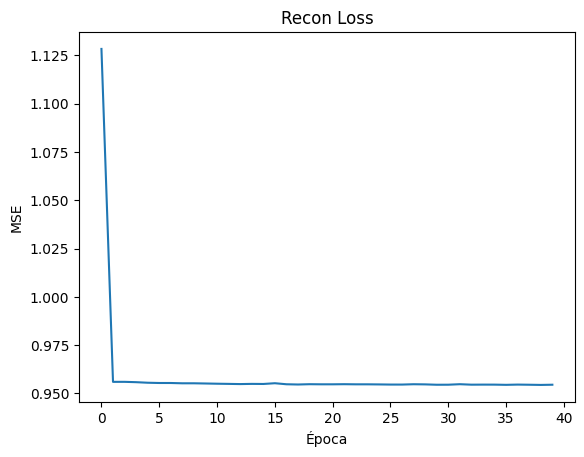

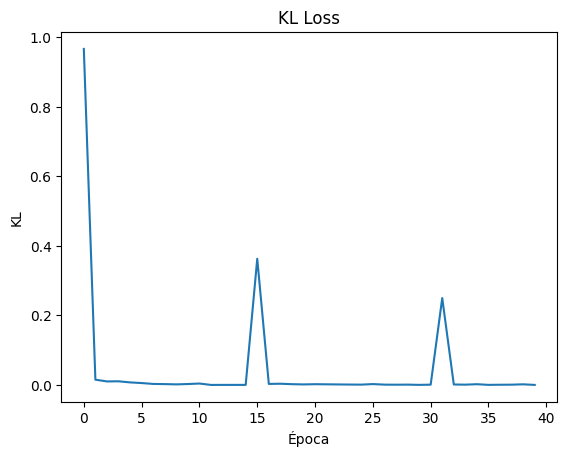

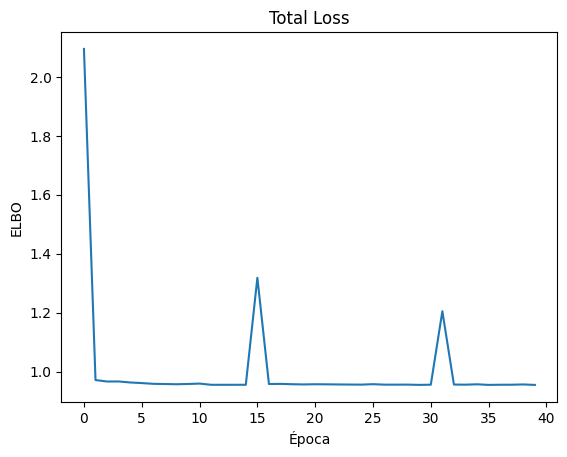

In [32]:

import matplotlib.pyplot as plt

plt.figure(); plt.plot(train_recon_losses); plt.title('Recon Loss'); plt.xlabel('Época'); plt.ylabel('MSE'); plt.show()
plt.figure(); plt.plot(train_kl_losses);    plt.title('KL Loss');    plt.xlabel('Época'); plt.ylabel('KL');  plt.show()
plt.figure(); plt.plot(train_total_losses); plt.title('Total Loss'); plt.xlabel('Época'); plt.ylabel('ELBO');plt.show()


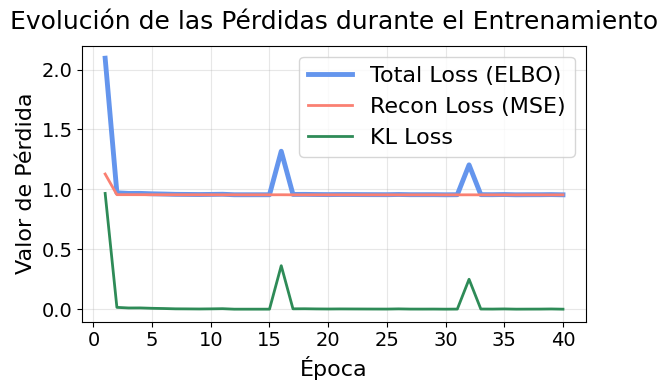

In [38]:
import matplotlib.pyplot as plt

from src.plot_metrics import plot_training_losses

plot_training_losses(train_recon_losses, train_kl_losses, train_total_losses, lw=2, font_size=16)

### Testing in train set before XGBoost

Calculamos KL, MSE, ELBO y scores

In [69]:
from torch.utils.data import DataLoader, TensorDataset

tr_loader_all = DataLoader(
    TensorDataset(
        torch.cat([train_norm_signal_tensor, train_ano_signal_tensor]),
        torch.cat([train_norm_coeffs_tensor, train_ano_coeffs_tensor]),
        torch.cat([torch.zeros(len(train_norm_signal_tensor)), torch.ones(len(train_ano_signal_tensor))])
    ),
    batch_size=batch_size
)

model.eval()
mse_list = []
kl_list  = []
labels_vae_tr   = []

with torch.no_grad():
    for x_s, x_c, y in tr_loader_all:
        x_s, x_c = x_s.to(device), x_c.to(device)
        recon, mu, logv = model(x_s, x_c)
        mse_batch = ((recon - x_s)**2).mean(dim=[1,2]).cpu().numpy()
        kl_batch  = (-0.5*(1 + logv - mu.pow(2) - logv.exp()).sum(dim=1)).cpu().numpy()

        mse_list.append(mse_batch)
        kl_list.append(kl_batch)
        labels_vae_tr.append(y.numpy())

mse_all_vae_tr = np.concatenate(mse_list)
kl_all_vae_tr  = np.concatenate(kl_list)
labels_vae_tr  = np.concatenate(labels_vae_tr)

In [70]:
print("MSE promedio:  normales =",
      mse_all_vae_tr[labels_vae_tr==0].mean(), 
      ", anómalos =", mse_all_vae_tr[labels_vae_tr==1].mean())
print("KL promedio:   normales =",
      kl_all_vae_tr[labels_vae_tr==0].mean(), 
      ", anómalos =", kl_all_vae_tr[labels_vae_tr==1].mean())

# -ELBO = mse + beta*kl como puntaje de anomalía
scores_vae_tr = mse_all_vae_tr + beta_value * kl_all_vae_tr
roc_auc_vae_tr = roc_auc_score(labels_vae_tr, scores_vae_tr)
print("ROC-AUC de detección de anomalías (VAE):", roc_auc_vae_tr)

MSE promedio:  normales = 0.9544195 , anómalos = 10.186241
KL promedio:   normales = 0.00017520432 , anómalos = 0.24252
ROC-AUC de detección de anomalías (VAE): 0.8164985144377043


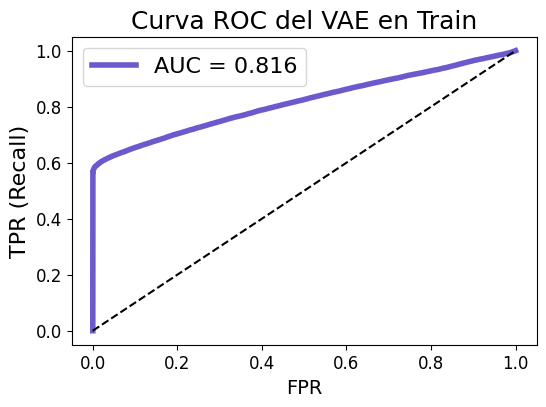

In [71]:
fpr, tpr, thr = roc_curve(labels_vae_tr, scores_vae_tr) 

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_vae_tr:.3f}", color = "slateblue", linewidth=4)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("TPR (Recall)", fontsize=16)
plt.title("Curva ROC del VAE en Train", fontsize=18)
plt.legend(fontsize = 16)
plt.show()

In [75]:
youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_threshold_vae = thr[best_idx]

print("Mejor umbral Youden J:", best_threshold_vae)

y_pred_vae_tr = (scores_vae_tr >= best_threshold_vae).astype(int)

from src.utils import display_metrics_as_md
    
metrics_vae = {
    'roc_auc': roc_auc_vae_tr,
    'precision': precision_score(labels_vae_tr, y_pred_vae_tr),
    'recall': recall_score(labels_vae_tr, y_pred_vae_tr),
    'f1': f1_score(labels_vae_tr, y_pred_vae_tr),
    'accuracy': accuracy_score(labels_vae_tr, y_pred_vae_tr) 
    }

display_metrics_as_md(metrics_vae, title="VAE Metrics on Train Set")

Mejor umbral Youden J: 2.805478


<h2 style='margin-bottom:0.3em'>VAE Metrics on Train Set</h2>
<p style='font-size:16px; margin:0.2em 0'><strong>Roc Auc:</strong> 0.8165</p>
<p style='font-size:16px; margin:0.2em 0'><strong>Precision:</strong> 0.9842</p>
<p style='font-size:16px; margin:0.2em 0'><strong>Recall:</strong> 0.6033</p>
<p style='font-size:16px; margin:0.2em 0'><strong>F1:</strong> 0.7481</p>
<p style='font-size:16px; margin:0.2em 0'><strong>Accuracy:</strong> 0.7289</p>


### Testing in validation set before XGBoost

In [73]:
val_norm_signal_tensor = torch.tensor(sig_vn).permute(0,2,1)   
val_norm_coeffs_tensor = torch.tensor(coe_vn)                 

val_ano_signal_tensor  = torch.tensor(sig_va).permute(0,2,1)    
val_ano_coeffs_tensor  = torch.tensor(coe_va)                 

# balancear val set
N_norm_val = len(val_norm_signal_tensor)
N_ano_val  = len(val_ano_signal_tensor)
N_val = min(N_norm_val, N_ano_val)

norm_signals_val = val_norm_signal_tensor[:N_val]
ano_signals_val  = val_ano_signal_tensor[:N_val]
norm_coeffs_val  = val_norm_coeffs_tensor[:N_val]
ano_coeffs_val   = val_ano_coeffs_tensor[:N_val]

X_val_final_signal = torch.cat([norm_signals_val, ano_signals_val], dim=0)
X_val_final_coeffs = torch.cat([norm_coeffs_val, ano_coeffs_val], dim=0)

y_val_final = torch.tensor(
    np.concatenate([np.zeros(N_val), np.ones(N_val)]),
    dtype=torch.long
)

val_loader_final = DataLoader(TensorDataset(X_val_final_signal, X_val_final_coeffs, y_val_final), batch_size=batch_size)

In [74]:
mse_list_val, kl_list_val, labels_val = [], [], []

with torch.no_grad():
    for x_s, x_c, y in val_loader_final:
        x_s, x_c = x_s.to(device), x_c.to(device)
        recon, mu, logv = model(x_s, x_c)
        mse_batch = ((recon - x_s)**2).mean(dim=[1,2]).cpu().numpy()
        kl_batch  = (-0.5*(1 + logv - mu.pow(2) - logv.exp()).sum(dim=1)).cpu().numpy()

        mse_list_val.append(mse_batch)
        kl_list_val.append(kl_batch)
        labels_val.append(y.numpy())

mse_all_vae_val = np.concatenate(mse_list_val)
kl_all_vae_val  = np.concatenate(kl_list_val)
labels_vae_val  = np.concatenate(labels_val)

scores_vae_val  = mse_all_vae_val + beta_value * kl_all_vae_val
y_pred_vae_val = (scores_vae_val >= best_threshold_vae).astype(int)

from src.utils import display_metrics_as_md
    
metrics_vae_val = {
    'roc_auc': roc_auc_score(labels_vae_val, scores_val),
    'precision': precision_score(labels_vae_val, y_pred_vae_val),
    'recall': recall_score(labels_vae_val, y_pred_vae_val),
    'f1': f1_score(labels_vae_val, y_pred_vae_val),
    'accuracy': accuracy_score(labels_vae_val, y_pred_vae_val) 
    }

display_metrics_as_md(metrics_vae_val, title="VAE Metrics on Val Set")

<h2 style='margin-bottom:0.3em'>VAE Metrics on Val Set</h2>
<p style='font-size:16px; margin:0.2em 0'><strong>Roc Auc:</strong> 0.8184</p>
<p style='font-size:16px; margin:0.2em 0'><strong>Precision:</strong> 0.9657</p>
<p style='font-size:16px; margin:0.2em 0'><strong>Recall:</strong> 0.6092</p>
<p style='font-size:16px; margin:0.2em 0'><strong>F1:</strong> 0.7471</p>
<p style='font-size:16px; margin:0.2em 0'><strong>Accuracy:</strong> 0.7938</p>


## `Fit XGBoost`

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix

In [50]:
X_tr_clf_signal = torch.cat([train_norm_signal_tensor, train_ano_signal_tensor], dim=0)
X_tr_clf_coeffs = torch.cat([train_norm_coeffs_tensor, train_ano_coeffs_tensor],   dim=0)
y_tr_clf     = torch.cat([
    torch.zeros(len(train_norm_signal_tensor), dtype=torch.long),
    torch.ones (len(train_ano_signal_tensor),  dtype=torch.long)
], dim=0)

tr_loader_clf = DataLoader(TensorDataset(X_tr_clf_signal, X_tr_clf_coeffs, y_tr_clf), batch_size=batch_size)

print("Extracting features from dev set for classifier training...")
errs_tr, zs_tr = compute_scores(model, tr_loader_clf, device, beta=beta_value)
errs_tr = np.nan_to_num(errs_tr, nan=0.0, posinf=1e6, neginf=-1e6)
zs_dev = np.nan_to_num(zs_tr, nan=0.0, posinf=1e6, neginf=-1e6)
X_train_clf = np.hstack([errs_tr.reshape(-1, 1), zs_dev])
y_train_clf = y_tr_clf.numpy()

print("Training XGBoost classifier...")
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train_clf, y_train_clf)
print("Classifier training complete.")

Extracting features from dev set for classifier training...
Training XGBoost classifier...


c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [15:11:23] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classifier training complete.


### Find Threshold in train (Youden’s J on ROC)

In [51]:
probs_val = clf.predict_proba(X_train_clf)[:, 1]
fpr_vtr, tpr_vtr, th_roc_vtr = roc_curve(y_train_clf, probs_val) 
j_scores_vtr = tpr_vtr - fpr_vtr
best_idx_vtr = np.argmax(j_scores_vtr)
best_thresh_vtr = th_roc_vtr[best_idx_vtr]
print(f"Umbral óptimo (Youden): {best_thresh_vtr:.3f}  →  TPR={tpr_vtr[best_idx_vtr]:.3f}, FPR={fpr_vtr[best_idx_vtr]:.3f}")

Umbral óptimo (Youden): 0.605  →  TPR=0.845, FPR=0.059


# Testing in validation set

In [ ]:
print("Extracting features from the validation set...")
errs_val, zs_val = compute_scores(model, val_loader_final, device, beta=beta_value)
errs_val = np.nan_to_num(errs_val, nan=0.0, posinf=1e6, neginf=-1e6)
zs_test = np.nan_to_num(zs_val, nan=0.0, posinf=1e6, neginf=-1e6)
X_val_clf = np.hstack([errs_val.reshape(-1, 1), zs_test])
y_val_clf = y_val_final.numpy()

Extracting features from the validation set...


### `Final Results in Validation set`

In [54]:
print("Evaluating classifier on the validation test...")
probs_val = clf.predict_proba(X_val_clf)[:, 1]
y_pred_val = (probs_val >= best_thresh_vtr).astype(int)

Evaluating classifier on the validation test...


In [ ]:
metrics = {
    'roc_auc': roc_auc_score(y_val_clf, probs_val),
    'precision': precision_score(y_val_clf, y_pred_val),
    'recall': recall_score(y_val_clf, y_pred_val),
    'f1': f1_score(y_val_clf, y_pred_val),
    'accuracy': accuracy_score(y_val_clf, y_pred_val)
}

from src.utils import display_metrics_as_md
display_metrics_as_md(metrics, "Final Metrics on Validation Set")

Evaluating classifier on the validation test...

--- Final Metrics on Unseen Test Set ---
{'roc_auc': np.float64(0.9235028718604121), 'precision': 0.87801766437684, 'recall': 0.8275830172971973, 'f1': 0.852054664063616, 'accuracy': 0.8563037646841181}


<h2 style='margin-bottom:0.3em'>Final Metrics on Validation Set</h2>
<p style='font-size:16px; margin:0.2em 0'><strong>Roc Auc:</strong> 0.9235</p>
<p style='font-size:16px; margin:0.2em 0'><strong>Precision:</strong> 0.8780</p>
<p style='font-size:16px; margin:0.2em 0'><strong>Recall:</strong> 0.8276</p>
<p style='font-size:16px; margin:0.2em 0'><strong>F1:</strong> 0.8521</p>
<p style='font-size:16px; margin:0.2em 0'><strong>Accuracy:</strong> 0.8563</p>


#### Confusion Matrix


Matriz de confusión:
           Pred Neg  Pred Pos
Real Neg      9568      1243
Real Pos      1864      8947


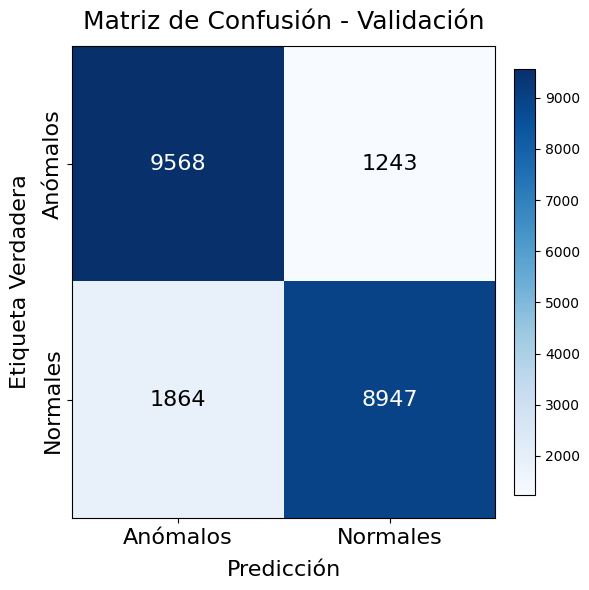

In [ ]:
cm_val = confusion_matrix(y_val_clf, y_pred_val) 

cm_val_df = pd.DataFrame(
    cm_val,
    index=["Real Neg","Real Pos"],
    columns=["Pred Neg","Pred Pos"]
)
print("\nMatriz de confusión:\n", cm_val_df)

from src.plot_metrics import plot_confusion_matrix

plot_confusion_matrix(cm_val, class_names=["Anómalos", "Normales"], title="Matriz de Confusión - Validación")

#### ROC and PR Curves

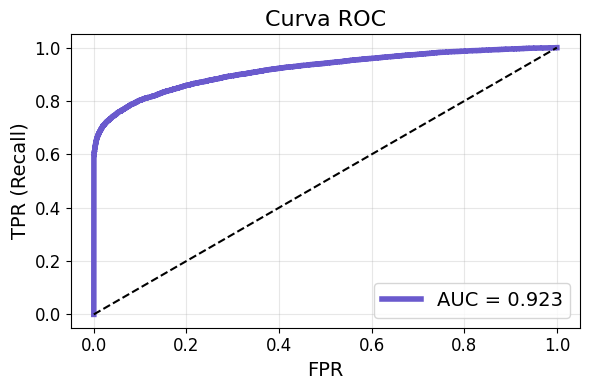

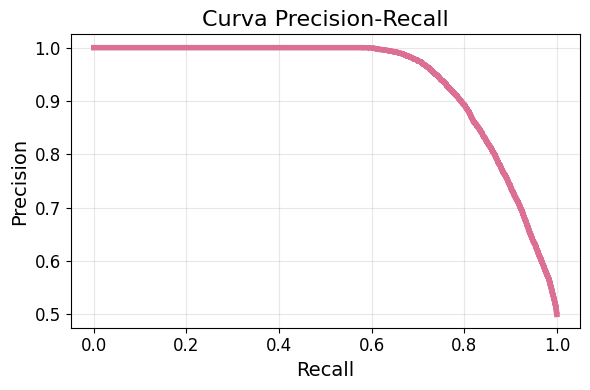

In [ ]:
from sklearn.metrics import roc_curve

from src.plot_metrics import plot_roc_pr

plot_roc_pr(y_val_clf, probs_val, lw=4, font_size=14, roc_color='slateblue', pr_color='palevioletred')

# `Final Training with full dev set`

In [110]:
latent_dim = best_hps['latent_dim']
lr = best_hps['lr']
n_blocks = best_hps['n_blocks']
beta_value = best_hps['beta']
epochs = 35

In [111]:
print(f"Using device: {device}, Signal Channels: {NUM_INPUT_CH}, Coeff Channels: {NUM_COEFF_CH}")

dev_ds = TensorDataset(dev_norm_signal_tensor, dev_norm_coeffs_tensor, torch.zeros(len(dev_norm_signal_tensor)))
dev_loader = DataLoader(dev_ds, batch_size=batch_size, shuffle=True)

model = VAE1D(input_ch=NUM_INPUT_CH, coeff_ch=NUM_COEFF_CH, latent_dim=latent_dim, n_blocks=n_blocks).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Using device: cuda, Signal Channels: 1, Coeff Channels: 21


In [ ]:
dev_recon_losses = []
dev_kl_losses    = []
dev_total_losses = []

print("Starting VAE training...")
for epoch in tqdm(range(epochs), desc="Training epochs"):
    model.train()
    total_loss = 0.0
    epoch_recon = 0.0
    epoch_kl    = 0.0
    for x_signal, x_coeffs, _ in tqdm(dev_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        x_signal, x_coeffs = x_signal.to(device), x_coeffs.to(device)
        
        recon, mu, logv = model(x_signal, x_coeffs)
        
        recon_loss = nn.functional.mse_loss(recon, x_signal)
        kl_loss = (-0.5 * (1 + logv - mu.pow(2) - logv.exp()).sum()) / x_signal.size(0)
        loss = recon_loss + beta_value * kl_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        epoch_recon += recon_loss.item() * x_signal.size(0)
        epoch_kl    += kl_loss.item()    * x_signal.size(0)

    N = len(dev_loader.dataset) 
    dev_recon_losses.append(epoch_recon / N)
    dev_kl_losses.append(epoch_kl / N)
    dev_total_losses.append(dev_recon_losses[-1] + beta_value * dev_kl_losses[-1])

    print(f"Epoch {epoch+1}/{epochs}  Recon={dev_recon_losses[-1]:.4f}  KL={dev_kl_losses[-1]:.4f}  Total={dev_total_losses[-1]:.4f},  VAE Loss: {total_loss/len(dev_loader):.4f}")

# Guardar el modelo
torch.save(model.state_dict(), f"{out_dir_models_n_params}/vae_model.pth")
print(f"VAE model saved to {out_dir_models_n_params}vae_model.pth")

Starting VAE training...


Training epochs:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 1/35  Recon=1.1260  KL=1.1337  Total=2.2597,  VAE Loss: 2.2592


Epoch 2/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 2/35  Recon=0.9562  KL=0.0151  Total=0.9713,  VAE Loss: 0.9713


Epoch 3/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 3/35  Recon=0.9560  KL=0.0094  Total=0.9653,  VAE Loss: 0.9654


Epoch 4/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 4/35  Recon=0.9560  KL=0.0103  Total=0.9663,  VAE Loss: 0.9663


Epoch 5/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 5/35  Recon=0.9559  KL=0.0076  Total=0.9635,  VAE Loss: 0.9635


Epoch 6/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 6/35  Recon=0.9555  KL=0.0048  Total=0.9603,  VAE Loss: 0.9603


Epoch 7/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 7/35  Recon=0.9556  KL=0.0033  Total=0.9590,  VAE Loss: 0.9590


Epoch 8/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 8/35  Recon=0.9554  KL=0.0029  Total=0.9583,  VAE Loss: 0.9582


Epoch 9/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 9/35  Recon=0.9553  KL=0.0030  Total=0.9583,  VAE Loss: 0.9583


Epoch 10/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 10/35  Recon=0.9552  KL=0.0008  Total=0.9561,  VAE Loss: 0.9560


Epoch 11/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 11/35  Recon=0.9552  KL=0.0005  Total=0.9557,  VAE Loss: 0.9557


Epoch 12/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 12/35  Recon=0.9560  KL=0.6466  Total=1.6027,  VAE Loss: 1.6024


Epoch 13/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 13/35  Recon=0.9552  KL=0.0121  Total=0.9673,  VAE Loss: 0.9673


Epoch 14/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 14/35  Recon=0.9550  KL=0.0036  Total=0.9586,  VAE Loss: 0.9586


Epoch 15/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 15/35  Recon=0.9550  KL=0.0031  Total=0.9582,  VAE Loss: 0.9581


Epoch 16/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 16/35  Recon=0.9550  KL=0.0028  Total=0.9579,  VAE Loss: 0.9578


Epoch 17/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 17/35  Recon=0.9549  KL=0.0060  Total=0.9608,  VAE Loss: 0.9608


Epoch 18/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 18/35  Recon=0.9549  KL=0.0019  Total=0.9567,  VAE Loss: 0.9567


Epoch 19/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 19/35  Recon=0.9550  KL=0.0018  Total=0.9568,  VAE Loss: 0.9568


Epoch 20/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 20/35  Recon=0.9549  KL=0.0037  Total=0.9586,  VAE Loss: 0.9585


Epoch 21/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 21/35  Recon=0.9550  KL=0.0014  Total=0.9564,  VAE Loss: 0.9563


Epoch 22/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 22/35  Recon=0.9549  KL=0.0009  Total=0.9558,  VAE Loss: 0.9558


Epoch 23/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 23/35  Recon=0.9548  KL=0.0027  Total=0.9575,  VAE Loss: 0.9574


Epoch 24/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 24/35  Recon=0.9548  KL=0.0009  Total=0.9557,  VAE Loss: 0.9557


Epoch 25/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 25/35  Recon=0.9548  KL=0.0011  Total=0.9559,  VAE Loss: 0.9558


Epoch 26/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 26/35  Recon=0.9554  KL=0.5788  Total=1.5342,  VAE Loss: 1.5339


Epoch 27/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 27/35  Recon=0.9548  KL=0.0038  Total=0.9586,  VAE Loss: 0.9587


Epoch 28/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 28/35  Recon=0.9548  KL=0.0015  Total=0.9563,  VAE Loss: 0.9563


Epoch 29/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 29/35  Recon=0.9548  KL=0.0013  Total=0.9562,  VAE Loss: 0.9562


Epoch 30/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 30/35  Recon=0.9549  KL=0.0021  Total=0.9570,  VAE Loss: 0.9570


Epoch 31/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 31/35  Recon=0.9548  KL=0.0022  Total=0.9570,  VAE Loss: 0.9571


Epoch 32/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 32/35  Recon=0.9548  KL=0.0019  Total=0.9567,  VAE Loss: 0.9566


Epoch 33/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 33/35  Recon=0.9548  KL=0.0013  Total=0.9560,  VAE Loss: 0.9560


Epoch 34/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 34/35  Recon=0.9548  KL=0.0070  Total=0.9617,  VAE Loss: 0.9617


Epoch 35/35:   0%|          | 0/845 [00:00<?, ?it/s]

Epoch 35/35  Recon=0.9548  KL=0.0003  Total=0.9551,  VAE Loss: 0.9552
VAE model saved to fmm_vae_model.pth


In [ ]:
os.makedirs(out_dir_models_n_params, exist_ok=True)

# solo los parámetros
torch.save(model.state_dict(), os.path.join(out_dir_models_n_params, "vae_state.pth"))
print(f"VAE model parameters saved to {os.path.join(out_dir_models_n_params, 'vae_state.pth')}")

VAE model parameters saved to C:/Users/anapt/Repositorios/TP-final_ML/TP-final_ML/ecg_project/models\vae_state.pth


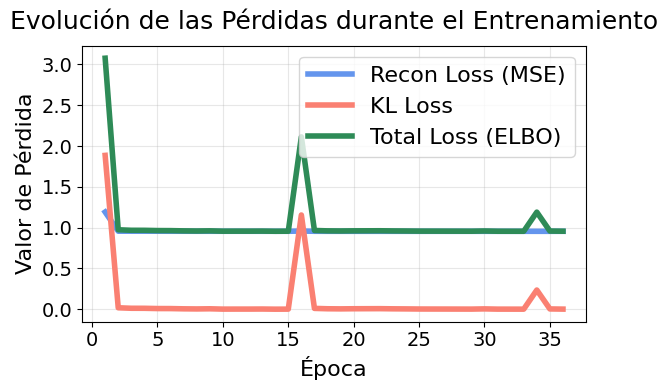

In [ ]:
import matplotlib.pyplot as plt

from src.plot_metrics import plot_training_losses

plot_training_losses(train_recon_losses, train_kl_losses, train_total_losses, lw=4, font_size=16)

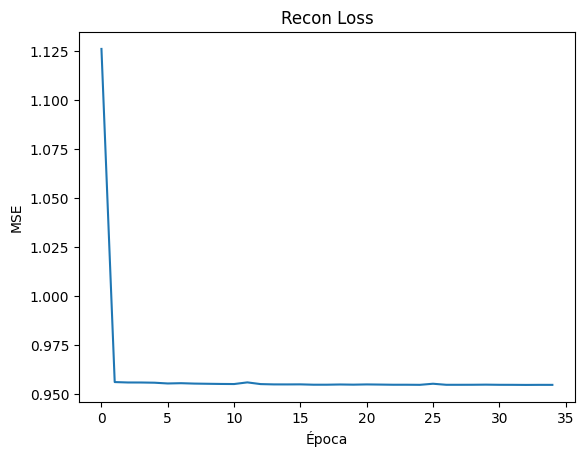

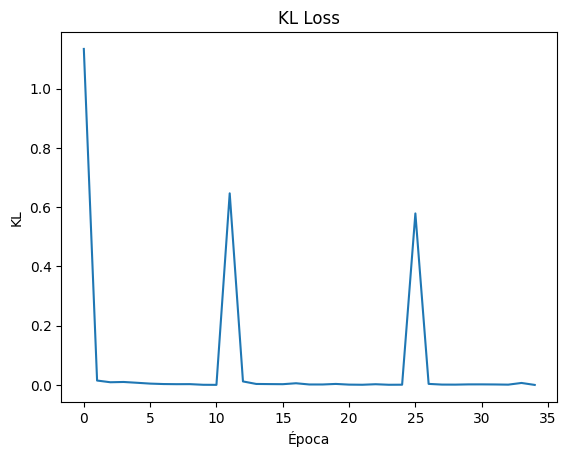

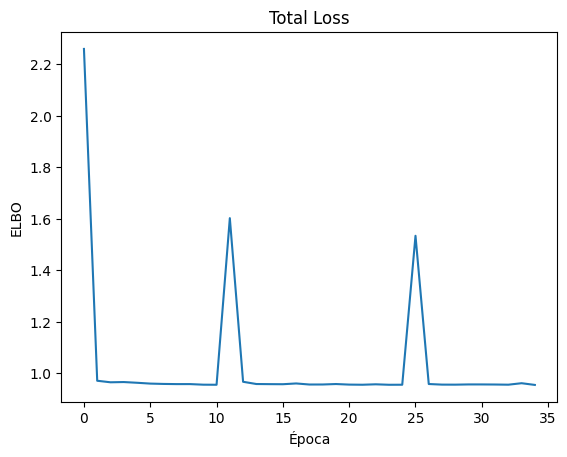

In [114]:

import matplotlib.pyplot as plt

plt.figure(); plt.plot(dev_recon_losses); plt.title('Recon Loss'); plt.xlabel('Época'); plt.ylabel('MSE'); plt.show()
plt.figure(); plt.plot(dev_kl_losses);    plt.title('KL Loss');    plt.xlabel('Época'); plt.ylabel('KL');  plt.show()
plt.figure(); plt.plot(dev_total_losses); plt.title('Total Loss'); plt.xlabel('Época'); plt.ylabel('ELBO');plt.show()


# XGBoost

In [118]:
X_dev_clf_signal = torch.cat([dev_norm_signal_tensor, dev_ano_signal_tensor], dim=0)
X_dev_clf_coeffs = torch.cat([dev_norm_coeffs_tensor, dev_ano_coeffs_tensor], dim=0)
y_dev_clf = torch.tensor(np.concatenate([np.zeros(len(dev_norm_signal_tensor)), np.ones(len(dev_ano_signal_tensor))]), dtype=torch.long)

dev_loader_clf = DataLoader(TensorDataset(X_dev_clf_signal, X_dev_clf_coeffs, y_dev_clf), batch_size=batch_size)


print("Extracting features from dev set for classifier training...")
errs_dev, zs_dev = compute_scores(model, dev_loader_clf, device, beta=beta_value)
errs_dev = np.nan_to_num(errs_dev, nan=0.0, posinf=1e6, neginf=-1e6)
zs_dev = np.nan_to_num(zs_dev, nan=0.0, posinf=1e6, neginf=-1e6)
X_dev_clf = np.hstack([errs_dev.reshape(-1, 1), zs_dev])
y_dev_clf = y_dev_clf.numpy()

print("Training XGBoost classifier...")
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf.fit(X_dev_clf, y_dev_clf)
print("Classifier training complete.")

Extracting features from dev set for classifier training...
Training XGBoost classifier...


c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [12:36:06] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classifier training complete.


In [119]:
probs_dev = clf.predict_proba(X_dev_clf)[:, 1]
fpr, tpr, th_roc = roc_curve(y_dev_clf, probs_dev)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_thresh = th_roc[best_idx]
print(f"Umbral óptimo (Youden): {best_thresh:.3f}  →  TPR={tpr[best_idx]:.3f}, FPR={fpr[best_idx]:.3f}")

Umbral óptimo (Youden): 0.584  →  TPR=0.839, FPR=0.061


## Save the final model

In [ ]:
# modelo
model_path = os.path.join(out_dir_models_n_params, "xgb_clf.joblib")
joblib.dump(clf, model_path)
print(f"Modelo XGBoost guardado en {model_path}")

# umbral en JSON
th_path = os.path.join(out_dir_models_n_params, "threshold.json")
with open(th_path, "w") as f:
    json.dump({"best_thresh": float(best_thresh)}, f)
print(f"Umbral guardado en {th_path}")

Modelo XGBoost guardado en C:/Users/anapt/Repositorios/TP-final_ML/TP-final_ML/ecg_project/models\xgb_clf.joblib
Umbral guardado en C:/Users/anapt/Repositorios/TP-final_ML/TP-final_ML/ecg_project/models\threshold.json
